# Terse version of SWH calculation

This is the stripped down (procedural) version of what would be done to calulate the significant wave height for one buoy (after having already retreived the data).

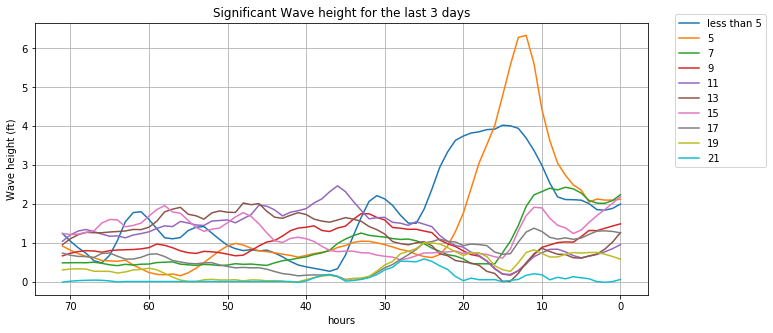

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import savgol_filter
np.set_printoptions(precision=2)

filename = '46053' # the buoy name
dest = './data/{}.data_spec'.format(filename)

dates = []
energies = []
frequencies = []

with open(dest) as fp:
    for _ in range(3):
        next(fp)    
    for l in fp:
        dates.append(l.split()[0:5])
        energies.append([float(e) for e in l.split()[6::2]])
        freqs=l.split()[7::2]
        frequencies.append([float(i[1:-1]) for i in freqs])
    fp.close()

E = np.array(energies)                       # E for 'Energy'
f = np.array(frequencies)                    # f for 'frequency'
df = np.diff(f)
fmid = .5*(f[:,:-1] + f[:,1:])               # only used to consider frequencies by period bins
Emid = .5*(E[:,:-1] + E[:,1:]) 

p = np.array([0,5,7,9,11,13,15,17,19,21,35]) # arbitrary periods
pmid = .5*(p[1:] + p[:-1])                   # mid-point resolution 

Pf = 1./fmid[0,:]                            # convert from frequency to period

# plotting options
fig, ax = plt.subplots()
fig.set_size_inches(11,5)
fig.savefig('SWH.png', dpi=100)

for idx, _ in enumerate(pmid):               # loop over period mid-point indexes (to make bins: period and neighbor)
    period_mask = (Pf > p[idx]) & (Pf <= p[idx+1]) # create a boolean mask of which period data will fit in this bin
    df_subset = df[:,period_mask]                  # subset of frequency 
    Emid_subset = Emid[:,period_mask]              # subset Energy
    variance = (df_subset*Emid_subset)              
    SWH = (4*np.sqrt(variance.sum(axis=1)))        # 4*(sqrt of variance) rerturns the 'crest to trough' wave height
    if idx == 0:             # creating a legend
        label = 'less than 5'
    else:
        label = p[idx]
    
    signif = SWH[0:72]*3.28                        # convert meters to feet
    smoothed = savgol_filter(signif, 7, 2)         # apply a Savitzky-Golay filter
    ax.plot(smoothed,label=label)                  # add it to the plot 


plt.gca().invert_xaxis()                          # invert the x axis (since it is looking back in time)
ax.set(xlabel='hours', ylabel='Wave height (ft)',
       title='Significant Wave height for the last 72 hours')
ax.legend(bbox_to_anchor=(1.2, 1.05))             # add the legend
ax.grid()
